<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from google.colab import drive
from keras import backend as K

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [4]:
def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = round(x - 0.5*s)
  x1 = round(x + 0.5*s)
  y0 = round(y - 0.5*s)
  y1 = round(y + 0.5*s)
  dx = (x1 - x0) - s
  dy = (y1 - y0) - s
  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0
    x1 -= dx
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1
    x0 += dx
  else:
    x0 += dx

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0
    y1 -= dy
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)
    y0 += dy
  else:
    y0 += dy

  return y0, y1, x0, x1

In [8]:
# Fungsi untuk mengekstrak ROI
# input : list centroid, panjang sisi ROI (s), dan image 
# output : ROI image

def ekstrakROI(centroid, s, img):
  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [61]:
def k_fold_cross_data(X, y, k=5, test_size=0.2, random_state=4):
  X_drishti = X[:50]
  X_refuge = X[50:]
  y_drishti = y[:50]
  y_refuge = y[50:]
  random.Random(random_state).shuffle(X_drishti)
  random.Random(random_state).shuffle(y_drishti)
  random.Random(random_state).shuffle(X_refuge)
  random.Random(random_state).shuffle(y_refuge)

  dataset = []

  for i in tqdm_notebook(range(k)):
    ix_test_dris = list(range(i*10, (i+1)*10))
    ix_test_ref = list(range(i*80, (i+1)*80))
    ix_train_dris = list(range(0, i*10)) + list(range((i+1)*10, 50))
    ix_train_ref = list(range(0, i*80)) + list(range((i+1)*80, 400))
    X_test = np.concatenate((X_drishti[ix_test_dris], X_refuge[ix_test_ref]))
    X_train = np.concatenate((X_drishti[ix_train_dris], X_refuge[ix_train_ref]))
    y_test = np.concatenate((y_drishti[ix_test_dris], y_refuge[ix_test_ref]))
    y_train = np.concatenate((y_drishti[ix_train_dris], y_refuge[ix_train_ref]))
    random.Random(random_state).shuffle(X_train)
    random.Random(random_state).shuffle(y_train)
    random.Random(random_state).shuffle(X_test)
    random.Random(random_state).shuffle(y_test)
    dataset.append([X_train, X_test, y_train, y_test])
  
  return dataset

In [75]:
def k_fold_crossval(X, y, callbacks, k=5, test_size=0.2, random_state=4):
  X_drishti = X[:50]
  X_refuge = X[50:]
  y_drishti = y[:50]
  y_refuge = y[50:]
  random.Random(random_state).shuffle(X_drishti)
  random.Random(random_state).shuffle(y_drishti)
  random.Random(random_state).shuffle(X_refuge)
  random.Random(random_state).shuffle(y_refuge)
  input_img = Input((256,256, 1), name='img')
  results = []

  for i in tqdm_notebook(range(k)):
    ix_test_dris = list(range(i*10, (i+1)*10))
    ix_test_ref = list(range(i*80, (i+1)*80))
    ix_train_dris = list(range(0, i*10)) + list(range((i+1)*10, 50))
    ix_train_ref = list(range(0, i*80)) + list(range((i+1)*80, 400))
    X_test = np.concatenate((X_drishti[ix_test_dris], X_refuge[ix_test_ref]))
    X_train = np.concatenate((X_drishti[ix_train_dris], X_refuge[ix_train_ref]))
    y_test = np.concatenate((y_drishti[ix_test_dris], y_refuge[ix_test_ref]))
    y_train = np.concatenate((y_drishti[ix_train_dris], y_refuge[ix_train_ref]))
    random.Random(random_state).shuffle(X_train)
    random.Random(random_state).shuffle(y_train)
    random.Random(random_state).shuffle(X_test)
    random.Random(random_state).shuffle(y_test)
    print('Evaluate fold ', i+1)
    model= get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", f1_m])
    result = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test), verbose=1)
    results.append(result)

  return results

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [62]:
X = []
y_OD = []
y_OC = []
dataset = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
shapes = []
for i in tqdm_notebook(range(0, len(df))):  
  center = df['disc_center'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)
  gt_OD = cv2.imread(df['path_OD_png'][i], 0)
  gt_OC = cv2.imread(df['path_OC_png'][i], 0)

  img,_ = ekstrakROI(center, 550, img)
  shapes.append(img.shape)
  gt_OD,_ = ekstrakROI(center, 550, gt_OD)
  gt_OC,_ = ekstrakROI(center, 550, gt_OC)
  img = resize(img, (256, 256, 1), mode = 'constant', preserve_range = True)
  gt_OD = resize(gt_OD, (256, 256, 1), mode = 'constant', preserve_range = True)
  gt_OC = resize(gt_OC, (256, 256, 1), mode = 'constant', preserve_range = True)
  X.append(img/255.0)
  y_OD.append(gt_OD/255.0)
  y_OC.append(gt_OC/255.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [63]:
X = np.array(X)
y_OD = np.array(y_OD)
y_OC = np.array(y_OC)

In [64]:
callbacks_OD = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=0),
    #ModelCheckpoint('model-OD.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
callbacks_OC = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=0),
    #ModelCheckpoint('model-OC.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
dataset_OD = k_fold_cross_data(X, y_OD, k=5, test_size=0.2, random_state=4)
dataset_OC = k_fold_cross_data(X, y_OC, callbacks, k=5, test_size=0.2, random_state=4)

X_train_OD, X_test_OD, y_train_OD, y_test_OD = dataset_OD[0]

In [29]:
X_train_OD1, X_test_OD1, y_train_OD1, y_test_OD1 = train_test_split(X, y_OD, 
                                                                test_size=0.2, 
                                                                random_state = 5)
X_train_OC1, X_test_OC1, y_train_OC1, y_test_OC1 = train_test_split(X, y_OC, 
                                                                test_size=0.2, 
                                                                random_state = 5)

In [21]:
input_img = Input((256,256, 1), name='img')

In [78]:
results_OD = k_fold_crossval(X, y_OD, callbacks_OD, k=5, random_state=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


Evaluate fold  1
Epoch 1/50
12/12 [==============================] - 20s 1s/step - loss: 0.5307 - accuracy: 0.7021 - f1_m: 0.6105 - val_loss: 1020.2650 - val_accuracy: 0.2720 - val_f1_m: 0.4383
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 0.1865 - accuracy: 0.9245 - f1_m: 0.8774 - val_loss: 791.0352 - val_accuracy: 0.2856 - val_f1_m: 0.4430
Epoch 3/50
12/12 [==============================] - 16s 1s/step - loss: 0.1539 - accuracy: 0.9323 - f1_m: 0.8893 - val_loss: 168.2070 - val_accuracy: 0.3553 - val_f1_m: 0.4693
Epoch 4/50
12/12 [==============================] - 16s 1s/step - loss: 0.1217 - accuracy: 0.9456 - f1_m: 0.9149 - val_loss: 90.2949 - val_accuracy: 0.3758 - val_f1_m: 0.4777
Epoch 5/50
12/12 [==============================] - 16s 1s/step - loss: 0.1142 - accuracy: 0.9476 - f1_m: 0.9197 - val_loss: 44.4750 - val_accuracy: 0.4074 - val_f1_m: 0.4908
Epoch 6/50
12/12 [==============================] - 17s 1s/step - loss: 0.0956 - accuracy: 0.9544 - f1_m

In [ ]:
results_OC = k_fold_crossval(X, y_OC, callbacks_OC, k=5, random_state=4)

In [72]:
model_OD = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OD.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', f1_m])

model_OC = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OC.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', f1_m])

In [ ]:
model_OD.summary()

In [ ]:
results_OD = model_OD.fit(X_train_OD, y_train_OD, batch_size=32, epochs=100, callbacks=callbacks_OD,\
                    validation_data=(X_test_OD, y_test_OD))

In [ ]:
results_OC = model_OC.fit(X_train_OC, y_train_OC, batch_size=32, epochs=100, callbacks=callbacks_OC,\
                    validation_data=(X_test_OC, y_test_OC))

In [93]:
def histo(histories):
  
  for i, histori in enumerate(histories):
    plt.figure(figsize=(20, 5))
    print('Fold-{}'.format(i+1))
    plt.subplot(131), 
    plt.plot(histori.history["accuracy"], label="accuracy")
    plt.plot(histori.history["val_accuracy"], label="val_acc")
    plt.plot(np.argmax(histori.history["val_accuracy"]), np.max(histori.history["val_accuracy"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(132), 
    plt.plot(histori.history["f1_m"], label="fscore")
    plt.plot(histori.history["val_f1_m"], label="val_fscore")
    plt.plot( np.argmax(histori.history["val_f1_m"]), np.max(histori.history["val_f1_m"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Fscore")
    plt.legend()
    plt.subplot(133),
    plt.plot(histori.history["loss"], label="loss")
    plt.plot(histori.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(histori.history["val_loss"]), np.min(histori.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.show()

Fold-1


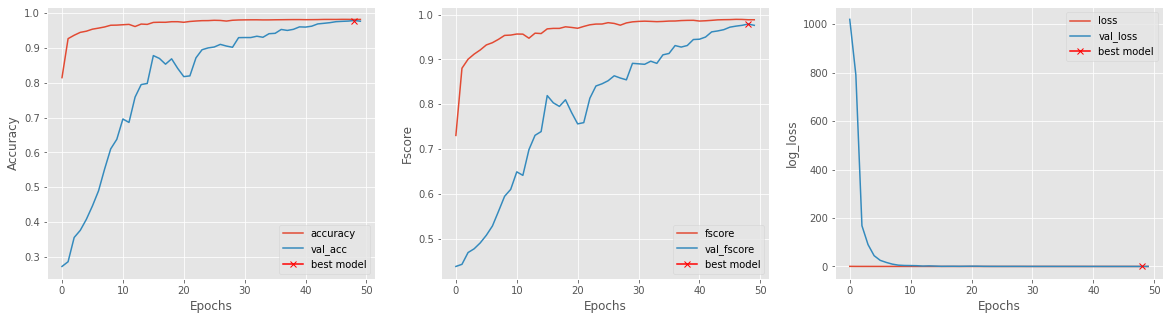

Fold-2


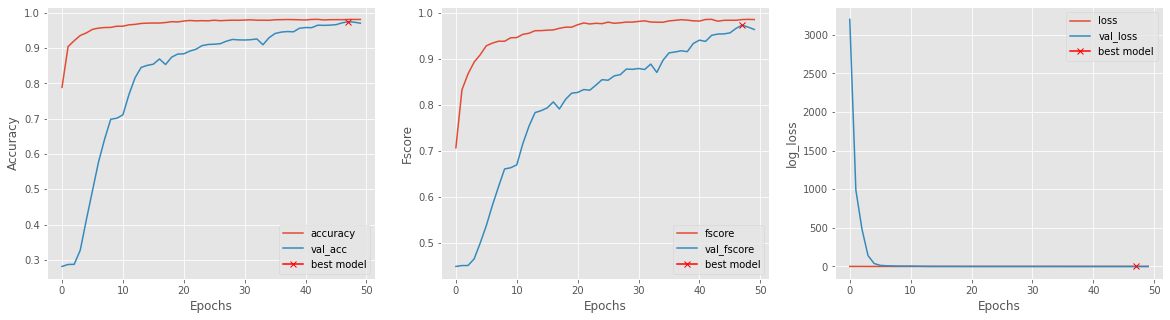

Fold-3


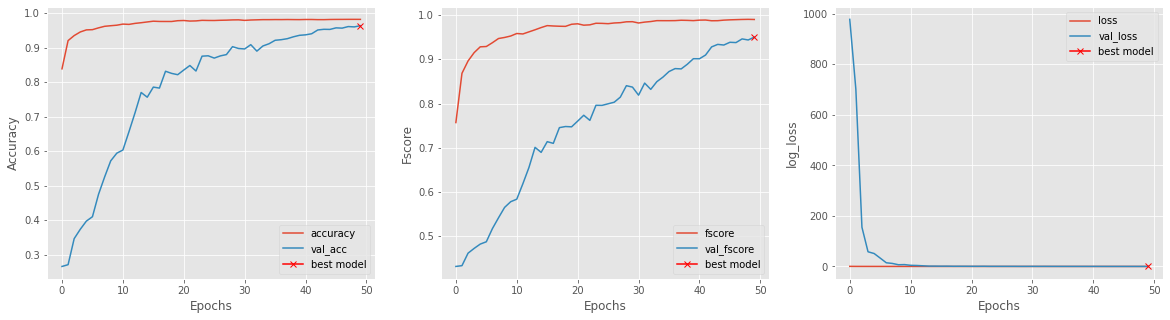

Fold-4


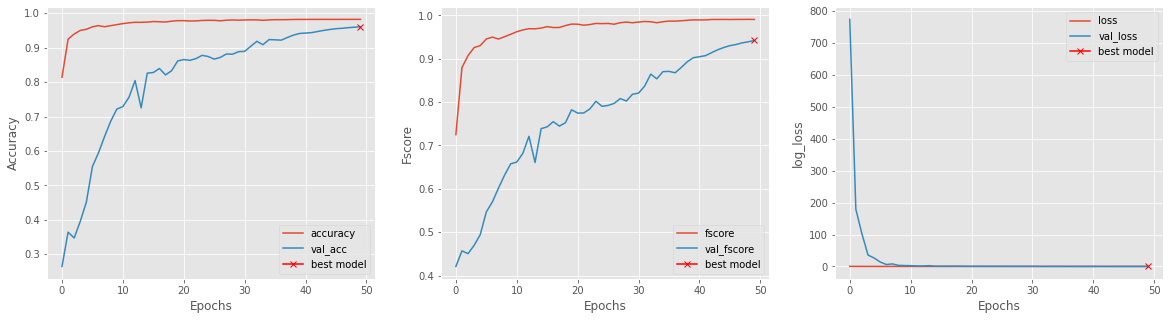

Fold-5


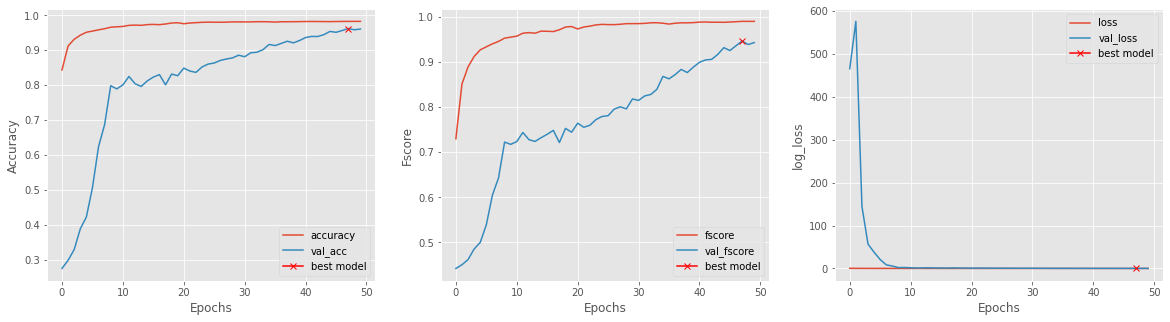

In [94]:
histo(results_OD)

In [ ]:
plt.figure(figsize=(14, 7))
plt.title("Learning curve")

plt.subplot(231), 
plt.plot(results_OD.history["accuracy"], label="accuracy")
plt.plot(results_OD.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(results_OD.history["val_accuracy"]), np.max(results_OD.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(232), 
plt.plot(results_OD.history["f1_m"], label="fscore")
plt.plot(results_OD.history["val_f1_m"], label="val_fscore")
plt.plot( np.argmin(results_OD.history["val_f1_m"]), np.max(results_OD.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Fscore")
plt.legend()
plt.subplot(233),
plt.plot(results_OD.history["loss"], label="loss")
plt.plot(results_OD.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_OD.history["val_loss"]), np.min(results_OD.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

plt.subplot(223), 
plt.plot(results_OC.history["f1_m"], label="f1_m")
plt.plot(results_OC.history["val_f1_m"], label="val_f1_m")
plt.plot( np.argmin(results_OC.history["val_f1_m"]), np.min(results_OC.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Fscore")
plt.legend()
plt.title("Learning curve")
plt.subplot(224),
plt.plot(results_OC.history["loss"], label="loss")
plt.plot(results_OC.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_OC.history["val_loss"]), np.min(results_OC.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()


In [ ]:
model_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')

# Inference

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
model_OD.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_OD.evaluate(X_test_OD, y_test_OD, verbose=1)
model_OC.evaluate(X_test_OC, y_test_OC, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train_OD = model_OD.predict(X_train_OD, verbose=1)
preds_val_OD = model_OD.predict(X_test_OD, verbose=1)
preds_train_OC = model_OC.predict(X_train_OC, verbose=1)
preds_val_OC = model_OC.predict(X_test_OC, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t_OD = (preds_train_OD > 0.5).astype(np.uint8)
preds_val_t_OD = (preds_val_OD > 0.5).astype(np.uint8)
preds_train_t_OC = (preds_train_OC > 0.5).astype(np.uint8)
preds_val_t_OC = (preds_val_OC > 0.5).astype(np.uint8)

In [ ]:
import scipy.ndimage
import cv2
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 5, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

    resample = cv2.resize(binary_preds[ix].squeeze(), (550, 550), interpolation = cv2.INTER_CUBIC)
    ax[4].imshow(resample)
    ax[4].set_title('resampled')
    print(resample.shape)

# Plot image

In [ ]:
# Check if training data looks all right
plot_sample(X_train_OD, y_train_OD, preds_train_OD, preds_train_t_OD, ix=30)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=30)

In [ ]:
plot_sample(X_train_OD, y_train_OD, preds_train_OD, preds_train_t_OD, ix=1)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=1)

# Saving model

In [ ]:
model_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')